In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import itertools
from tqdm import trange

from agents.dqn import DoubleDQNAgent, QNetwork
from environment.env import GridEnvDeform, POMDPWrapper_v0
import matplotlib.pyplot as plt
from utils.belief import update_belief



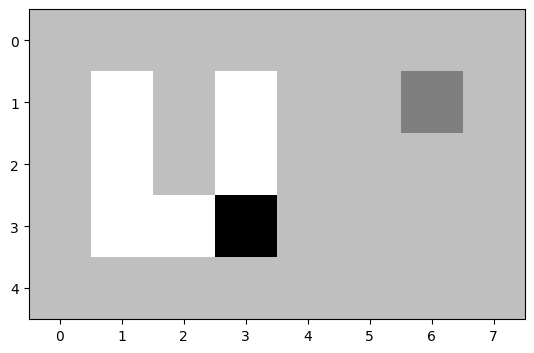

States: 144, Actions: 4, Observations 32, Thetas [(1, 1), (2, 1)]



In [3]:
# maze size
N = 2

# thetas deformations (range(a,b),range(c,d))
l0 = 1
h0 = 3
l1 = 1
h1 = 2

maze = np.load(f"maze/maze_{N}.npy")
env = GridEnvDeform(maze,l0,h0,l1,h1)
env.render()

states = [((x,y,phi),(i,j)) for x in range(1,env.max_shape[0]-1) for y in range(1,env.max_shape[1]-1) for phi in range(4) for i in range(l0,h0) for j in range(l1,h1)] 
actions = [0,1,2,3]
obs = list(itertools.product([0,1], repeat=5))
thetas = [(i,j) for i in range(l0,h0) for j in range(l1,h1)]

state_dict = {state: i for i, state in enumerate(states)}
obs_dict = {obs : i for i, obs in enumerate(obs)}

# Actions are: 0-listen, 1-open-left, 2-open-right
lenS = len(states)
lenA = len(actions)
lenO = len(obs)

print(f"States: {lenS}, Actions: {lenA}, Observations {lenO}, Thetas {thetas}\n")

T = torch.load(f"models/T_maze_{N}.pt", weights_only=True)
R = torch.load(f"models/R_maze_{N}.pt", weights_only=True)
O = torch.load(f"models/O_maze_{N}.pt", weights_only=True)


# POMDP  train


In [4]:
agent = DoubleDQNAgent(state_dim=144, action_dim=4, lr = 0.01)

pomdp_env = POMDPWrapper_v0(env, agent, T, R, O, state_dict, obs_dict, thetas)

In [5]:
num_episodes = 1000
max_episode_steps = 100

rewards = []
evalrewards = []

for episode in trange(num_episodes):
    
    obs, info = pomdp_env.reset()
    s = info['actual_state']

    b_0 = torch.ones(len(states)) / len(states)   
    b = update_belief(b_0, 0, obs, T,O)
    
    episode_reward = 0
    done = False
    
    steps = 0
    while not done and steps < max_episode_steps:
        
        for action in range(4):
            next_obs, reward, done, info = pomdp_env.step(s,action)
            b_prime = update_belief(b, action,obs,T,O)
            agent.store_transition(b, action, reward, b_prime, done)

        action = agent.choose_action(b)
        obs, reward, done, info = pomdp_env.step(s,action)
        next_state = info['actual_state']
        b_prime = update_belief(b, action,obs,T,O)


        agent.train()
        b = b_prime
        s = next_state

        episode_reward += reward
        steps += 1        
    
    agent.update_epsilon()
    rewards.append(episode_reward)
            


print("Training complete.")


  0%|          | 0/1000 [00:00<?, ?it/s]

  4%|▎         | 37/1000 [00:08<03:53,  4.12it/s]


KeyboardInterrupt: 